<a href="https://colab.research.google.com/github/casper6020/Syed_tahfim_projects/blob/main/Classification_XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries and Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
# drive.mount('/content/drive')

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/static/public/2/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


### Exploratory Data Analysis

In [4]:
#Let's Check the number of missing values in each variable
df.isnull().sum()

,0
age,0
workclass,963
fnlwgt,0
education,0
education-num,0
marital-status,0
occupation,966
relationship,0
race,0
sex,0


*The workclass, occupation and native-country variables are categorical and have some missing values. Let's check their values.*

In [5]:
var_with_missing_vals = [var for var in df.columns if df[var].isnull().mean() > 0]

for var in var_with_missing_vals:
  print(df[var].unique())

['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked' nan]
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv' nan]
['United-States' 'Cuba' 'Jamaica' 'India' '?' 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'England' 'Canada' 'Germany' 'Iran'
 'Philippines' 'Italy' 'Poland' 'Columbia' 'Cambodia' 'Thailand' 'Ecuador'
 'Laos' 'Taiwan' 'Haiti' 'Portugal' 'Dominican-Republic' 'El-Salvador'
 'France' 'Guatemala' 'China' 'Japan' 'Yugoslavia' 'Peru'
 'Outlying-US(Guam-USVI-etc)' 'Scotland' 'Trinadad&Tobago' 'Greece'
 'Nicaragua' 'Vietnam' 'Hong' 'Ireland' 'Hungary' 'Holand-Netherlands' nan]


*In addition to null values, there are data points with abnormal values like "?". Let's check if there are other variables with such abnormal values.*

In [6]:
for var in df.columns:
  if '?' in df[var].unique():
    print(var)

workclass
occupation
native-country


*So, there are the only three variables with such values.*

In [7]:
#Let's convert them to null values.
for var in var_with_missing_vals:
  df[var] = df[var].replace('?', np.nan)

In [8]:
df.isna().sum()

,0
age,0
workclass,2799
fnlwgt,0
education,0
education-num,0
marital-status,0
occupation,2809
relationship,0
race,0
sex,0


In [9]:
#Lets check the values of the dependent variable
df['income'].value_counts(normalize=True)

,proportion
income,
<=50K,0.506122
<=50K.,0.254596
>50K,0.160538
>50K.,0.078744


*Seems there are unnecessary puntuation in the values. Let's clean them.*

In [10]:
print(df['income'].unique())
df['income'] = df['income'].str.strip(".")
print(df['income'].unique())

['<=50K' '>50K' '<=50K.' '>50K.']
['<=50K' '>50K']


In [11]:
# Step 1: Calculate missing value counts for each category of target variable

missing_values = {}

for var in var_with_missing_vals:
    missing = df[df[var].isnull()].groupby('income').size()
    total = df.groupby('income').size()
    proportion = (missing / total) * 100
    missing_values[var] = pd.DataFrame({'proportion': proportion})

In [12]:
missing_values['workclass']

,proportion
income,
<=50K,6.820078
>50K,2.267477


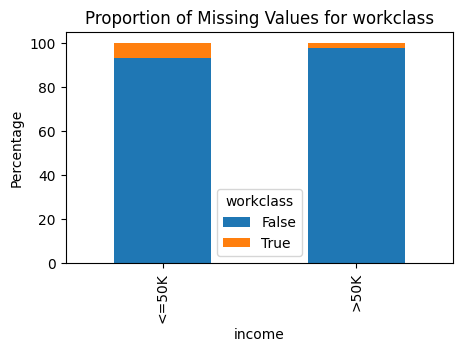

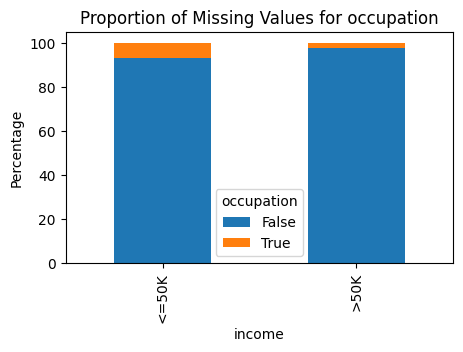

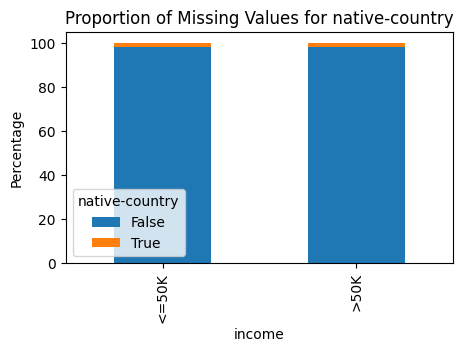

In [13]:
# Stacked bar plot for proportions
for var in var_with_missing_vals:
    missing_prop = pd.crosstab(df[var].isnull(), df['income'], normalize='columns') * 100
    missing_prop.T.plot(kind='bar', stacked=True, figsize=(5, 3))
    plt.title(f'Proportion of Missing Values for {var}')
    plt.ylabel('Percentage')
    plt.show()

*The proportion of missing values are negligible. Therefore, we drop the data point with missing values.*

In [14]:
cleaned_df = df.dropna()

In [15]:
cleaned_df.shape

(45222, 15)

*Let's check for redundant variables.*

In [16]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45222 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45222 non-null  int64 
 1   workclass       45222 non-null  object
 2   fnlwgt          45222 non-null  int64 
 3   education       45222 non-null  object
 4   education-num   45222 non-null  int64 
 5   marital-status  45222 non-null  object
 6   occupation      45222 non-null  object
 7   relationship    45222 non-null  object
 8   race            45222 non-null  object
 9   sex             45222 non-null  object
 10  capital-gain    45222 non-null  int64 
 11  capital-loss    45222 non-null  int64 
 12  hours-per-week  45222 non-null  int64 
 13  native-country  45222 non-null  object
 14  income          45222 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


*education and education-num denotes same feature, so we can remove education-num.*

In [17]:
cleaned_df.drop(['education-num'],axis=1,inplace=True)

In [36]:
cleaned_df['income'].value_counts(normalize=True)

,proportion
income,
<=50K,0.752156
>50K,0.247844


#### Encoding the categorical variables

In [43]:
# Before we encode the categorical variables, separate the dependent variable from the dataset
X = cleaned_df.drop(['income'], axis=1)
y = cleaned_df['income'].values

In [44]:
X_dum = pd.get_dummies(X, drop_first=True)

In [45]:
X_dum.shape

(45222, 95)

In [46]:
np.unique(y)

array(['<=50K', '>50K'], dtype=object)

In [47]:
y = np.where(y == '>50K',1,0)
np.unique(y)

array([0, 1])

### Model Development
*Let's create train, evaluation and test set using train_test_split.*

In [55]:
from sklearn.model_selection import train_test_split
X_train_full, X_eval, y_train_full, y_eval = train_test_split(X_dum, y, test_size = 0.3, random_state = 0)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size = 0.3, random_state = 0)

#### Logistic Regression

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

lgr_clf = LogisticRegression(solver='liblinear', random_state=42)
# Fit the model on the training set
lgr_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_lgr = lgr_clf.predict(X_test)

# Evaluate the model
lg_accu = accuracy_score(y_test, y_pred_lgr)
lg_roc_auc = roc_auc_score(y_test, y_pred_lgr)

In [61]:
print('Logistic Regression Accuracy:', round(lg_accu,4) * 100)
print('Logistic Regression ROC AUC:', round(lg_roc_auc,4) * 100)

Logistic Regression Accuracy: 79.64
Logistic Regression ROC AUC: 61.5


#### Xtreme Gradient Boosting

In [62]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(n_estimators = 100,
                        learning_rate = 0.05,
                        use_label_encoder = False,
                        eval_metric = "logloss",
                        early_stopping_rounds = 5,
                        n_jobs = -1)

In [63]:
xgb_clf.fit(X_train, y_train,
            eval_set = [(X_eval,y_eval)],
            verbose = False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [64]:
# Predict on the test set
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluate the model
xgb_accu = accuracy_score(y_test, y_pred_xgb)
xgb_roc_auc = roc_auc_score(y_test, y_pred_xgb)

In [65]:
print('Logistic Regression Accuracy:', round(xgb_accu,4) * 100)
print('Logistic Regression ROC AUC:', round(xgb_roc_auc,4) * 100)

Logistic Regression Accuracy: 86.77
Logistic Regression ROC AUC: 77.42999999999999
